## Loading the data

Now that we have a dataset of labeled samples from the active learning process, we can train a model on this dataset.

Let's load the data from the active learning process.

In [1]:
import pandas as pd

df = pd.read_parquet("active_labeled.parquet")
df

filepath             label
0    data/imagenette/train/n02102040/n02102040_2788...  English springer
1    data/imagenette/train/n02102040/n02102040_3759...  English springer
2    data/imagenette/train/n02102040/n02102040_1916...  English springer
3    data/imagenette/train/n02102040/n02102040_6147...  English springer
4    data/imagenette/train/n02102040/n02102040_403....  English springer
..                                                 ...               ...
238  data/imagenette/train/n03417042/n03417042_1869...     garbage truck
239  data/imagenette/train/n02102040/n02102040_6763...  English springer
240  data/imagenette/train/n01440764/n01440764_1455...             tench
241  data/imagenette/train/n03028079/n03028079_2489...            church
242  data/imagenette/train/n03425413/n03425413_2110...          gas pump

[243 rows x 2 columns]


## Training the model
We will use the fastai to train a model on this dataset. Feel free to use any other library you prefer.

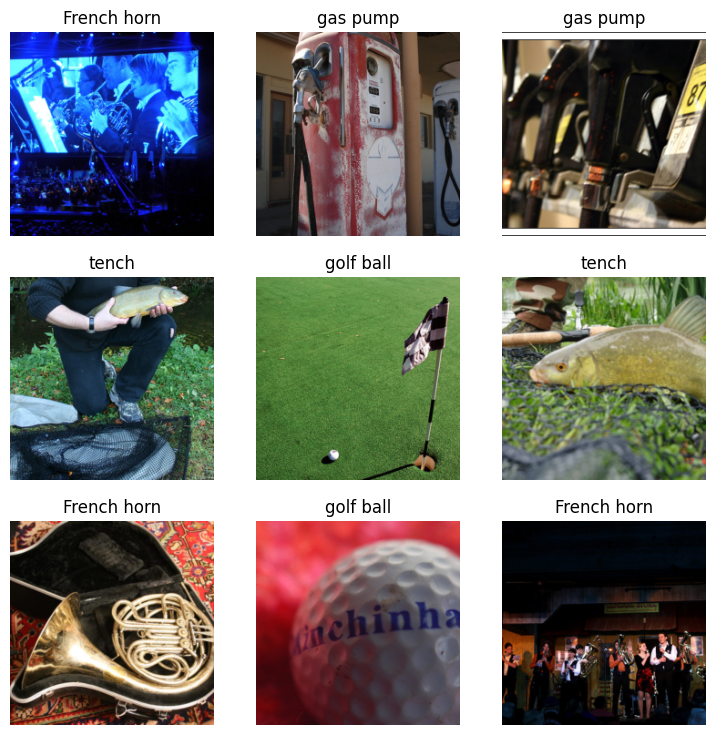

In [6]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
)

dls.show_batch()

In [7]:
learn = vision_learner(dls, "vit_small_patch16_224", metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, b

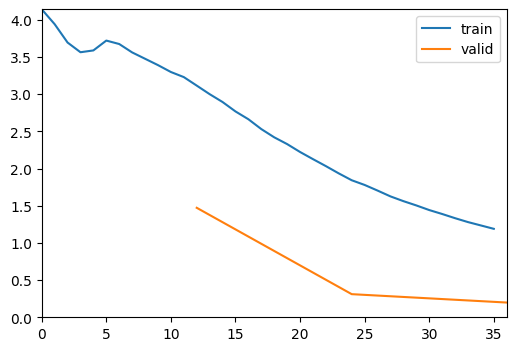

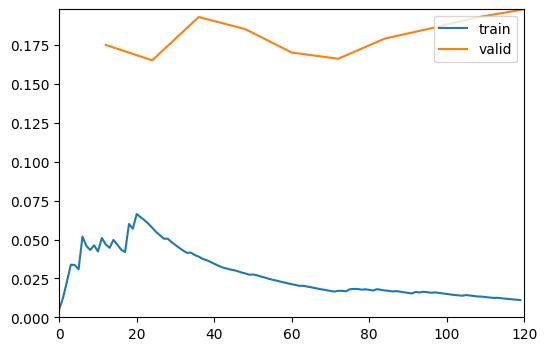

In [8]:
learn.fine_tune(10, base_lr=5e-3, freeze_epochs=3, cbs=ShowGraphCallback())


## Evaluating the model

In [10]:
test_df = pd.read_parquet("evaluation_samples.parquet")
test_df

filepath  \
0             data/imagenette/val/n03394916/n03394916_32422.JPEG   
1             data/imagenette/val/n03394916/n03394916_69132.JPEG   
2             data/imagenette/val/n03394916/n03394916_33771.JPEG   
3             data/imagenette/val/n03394916/n03394916_29940.JPEG   
4     data/imagenette/val/n03394916/ILSVRC2012_val_00033682.JPEG   
...                                                          ...   
3920          data/imagenette/val/n02979186/n02979186_27392.JPEG   
3921           data/imagenette/val/n02979186/n02979186_2742.JPEG   
3922           data/imagenette/val/n02979186/n02979186_2312.JPEG   
3923          data/imagenette/val/n02979186/n02979186_12822.JPEG   
3924  data/imagenette/val/n02979186/ILSVRC2012_val_00042982.JPEG   

                label  
0         French horn  
1         French horn  
2         French horn  
3         French horn  
4         French horn  
...               ...  
3920  cassette player  
3921  cassette player  
3922  cassette player  
3923  cassette player  
3924  cassette player  

[3925 rows x 2 columns]

In [11]:
filepaths = test_df["filepath"].tolist()
labels = test_df["label"].tolist()
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

results = pd.DataFrame(
    {
        "filepath": filepaths,
        "label": labels,
        "pred_label": [learn.dls.vocab[i] for i in cls_preds.numpy()],
    }
)

accuracy = float((results["label"] == results["pred_label"]).mean())
accuracy


/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, b

0.9936305732484076

With a mere 243 labeled samples, we have achieved an accuracy of 99.36% on the test set. The entire dataset contains over 9000 images, but it turns out that using active learning, we can achieve a high accuracy with a small number of labeled samples.